# 1. Знакомство с данными

**Наименование исследования: "Анализ оттока клиентов банка"**

- **Цель исследования:** с помощью имеющихся данных предоставить рекомендацию менеджеру продукта/маркетологу о причинах оттока клиентов в трех городах, где представлена филиальная сеть банка

- **Задачи исследования:** выявить зависимости факта оттока с количеством продуктов, возрастом клиентов, городом, где расположен банк и прочих факторов, которые имеются в данных

**Ожидаемый результат исследования:** предоставление обоснованной рекомендации менеджеру продукта/маркетологу о причинах оттока клиентов и основные рекомендации по улучшению ситуации

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.
**Колонки:**
- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- Age — возраст,
- Objects — количество объектов в собственности,
- Balance — баланс на счёте,
- Банки — Анализ оттока клиентов 2
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — есть ли кредитная карта,
- Loyalty — активный клиент,
- estimated_salary — заработная плата клиента,
- Churn — ушёл или нет.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/bank_dataset.csv')
data.sample(10)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
1846,15855074,485,Рыбинск,Ж,30,7,NaN,1,1,0,107067.37,0
6566,15752259,525,Ростов Великий,Ж,30,0,157989.21,2,1,1,100687.67,0
1515,15645233,850,Рыбинск,М,39,6,133214.13,1,0,1,20769.88,0
9015,15640121,573,Рыбинск,М,41,5,NaN,2,0,1,14479.29,0
6467,15684518,540,Ярославль,Ж,31,7,NaN,1,0,1,183051.60,1
620,15725321,593,Ярославль,М,35,9,114193.24,1,1,0,71154.10,0
4708,15854721,530,Рыбинск,М,44,6,NaN,2,0,0,55893.37,0
4196,15839646,625,Рыбинск,Ж,57,7,NaN,1,0,0,84106.17,1
6013,15652635,548,Рыбинск,М,37,4,NaN,1,1,0,121763.68,0
9704,15802608,625,Ярославль,М,22,9,NaN,2,1,0,157072.91,0


На выборке 10 случайных строк бросаются в глаза NaN'ы. Запомним это и посмотрим, что можно с этим сделать на этапе предобработки

Посмотрим, сколько в данных строк и столбцов.

In [3]:
print('Количество записей в таблице:', len(data))
print()
print('Количество столбцов в таблице:', len(data.columns))

Количество записей в таблице: 10000

Количество столбцов в таблице: 12


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


В целом, с типами данных все хорошо. Немного выделяется "дробная" часть в столбцах с балансом и зарплатой, но, т.к. в ТЗ не содержится никакой оговорки на этот счет, трогать их не будем. Все-таки, в банковском деле важна точность :)

В тоже время, видим, что в столбце Balance записей сильно меньше, чем во всех других. Очевидно, те самые пропуски. Проверим, на сколько этот столбец "неполноценен" в процентном соотношении:

In [5]:
print('Процент пропусков в столбце Balance:', (data['Balance'].isna().sum() / len(data) * 100).round(1))

Процент пропусков в столбце Balance: 36.2


36,2% - однозначный повод проанализировать это явление на стадии предобработки. В остальном, все хорошо

In [6]:
data.duplicated().sum()

0

Дубликатов нет. "Неявные" дубликаты/синонимы тоже не прослеживаются.

Все столбцы с "типовыми" значениями, вроде churn или gender проверены методом unique - значений "из ряда вон выходящих" не имеется. Также, возраст клиентов от 18 до 92 лет, в общем-то, ничего невозможного.

Видим также, что названия столбцов указаны не на змеином регистре, что не очень хорошо. Также, исправим это на этапе предобработки.

**Выводы:**
- были подключены необходимые библиотеки
- отмечены особенности и недочеты в данных
- в исследовании будут "принимать участие" данные о 10000 клиентов банка

# 2. Предобработка и детальное изучение данных

Начнем с приведения столбцов к змеиному регистру:

In [7]:
data.columns = data.columns.str.lower()
display(data.columns.tolist())

['userid',
 'score',
 'city',
 'gender',
 'age',
 'objects',
 'balance',
 'products',
 'creditcard',
 'loyalty',
 'estimated_salary',
 'churn']

В двух столбцах наименования не разделены "нижним подчеркиванием". Исправим:

In [8]:
data.columns = ['user_id',
 'score',
 'city',
 'gender',
 'age',
 'objects',
 'balance',
 'products',
 'credit_card',
 'loyalty',
 'estimated_salary',
 'churn']

Относительно природы пропусков в столбце balance есть 2 мысли:
- на месте пропусков нули, то есть пропуск равен отсутствию средств
- на месте пропуска отрицательные значения. Может быть это лица имеющие кредитные продукты, соответственно, сумма их долга указана с минусом. Например: -5000. Но, по неизвестным причинам, все отрицательные значения обратились в пропуски. Проверим, сколько записей из стобца балансе имеют значение 0, а сколько отрицательных, если они есть

In [9]:
print('Баланс менее нуля:', len(data.query('balance < 0')))
print()
print('Баланс равен нулю:', len(data.query('balance == 0')))
print()
print('Баланс более нуля:', len(data.query('balance > 0')))

Баланс менее нуля: 0

Баланс равен нулю: 0

Баланс более нуля: 6383


Из сделанных мной предположений, больше склоняюсь остановиться на первой версии, что пропуск = 0. Считаю, нужно оставить их как есть, т.к. заменить средним или медианой индивидуальный показатель будет крайне некорректно, а заменить 36% значений нулем исказит любую визуализацию (будет "скопление" в области нуля)

Также, проверим еще одну версию, что пропуски - это результат неудачной выгрузки/обработки данных на предыдущих стадиях работы с ними. Для этого создадим столбец, аналогичный churn, в котором, значение 1 - пропуск в столбце баланса, 0 - заполнено какое-то значение

In [10]:
data['balance_nan'] = 1
data.loc[data['balance'] >= 0, 'balance_nan'] = 0

Посмотрим на результаты группировки средних значений данных где есть пропуск и где их нет:

In [11]:
data.groupby('balance_nan').mean()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
balance_nan,,,,,,,,,,
0,1.573310e+07,651.138493,39.197713,4.979633,119827.493793,1.386025,0.699201,0.513552,100717.352956,0.240796
1,1.573469e+07,649.452861,38.434891,5.071330,NaN,1.784628,0.716616,0.517832,98983.559549,0.138236


Видна разница в количестве продуктов, в то время, как другие показатели почти идентичны. Проверим:

In [12]:
display(data.groupby('products')['balance_nan'].mean().reset_index())

,products,balance_nan
0,1,0.178009
1,2,0.566449
2,3,0.368421
3,4,0.233333


У клиентов, имеющих 2 продукта процент пропусков сильно выше, чем у других значений - 56%

In [13]:
display(data.groupby('city')['balance_nan'].mean().reset_index())

,city,balance_nan
0,Ростов Великий,0.000000
1,Рыбинск,0.484053
2,Ярославль,0.482250


Есть зацепка по городу: в Ростове Великом пропусков нет вообще. Тут 2 версии, либо неудачная выгрузка, либо в двух других городах филиальной сети банка есть некие проблемы с заполнением/обработкой данных, как технического характера, так и человеческий фактор

Переберем группировки по другим параметрам:

In [14]:
display(data.groupby('loyalty')['balance_nan'].mean().reset_index())

,loyalty,balance_nan
0,0,0.359662
1,1,0.363619


In [15]:
display(data.groupby('gender')['balance_nan'].mean().reset_index())

,gender,balance_nan
0,Ж,0.364077
1,М,0.359721


In [16]:
display(data.groupby('credit_card')['balance_nan'].mean().reset_index())

,credit_card,balance_nan
0,0,0.348048
1,1,0.367399


In [17]:
display(data.groupby('churn')['balance_nan'].mean().reset_index())

,churn,balance_nan
0,0,0.391435
1,1,0.245459


In [18]:
display(data.groupby('objects')['balance_nan'].mean().reset_index())

,objects,balance_nan
0,0,0.331719
1,1,0.337198
2,2,0.364504
3,3,0.348860
4,4,0.373104
5,5,0.369565
6,6,0.379524
7,7,0.375486
8,8,0.354146
9,9,0.365854


Везде процент пропусков почти идентичен. Несколько выделяется показатель оттока: у ушедших процент пропусков меньше, чем у действующих

Увы, выявленные закономерности пропусков в двух отделениях банка и для клиентов, имеющих 2 продукта не позволяют чем-либо их заполнить, т.к. доход - индивидуальный показатель. Придется оставить, как есть, но в идеале, стоит запросить природу пропусков у ответственного лица и учесть это в расчетах, либо запросить более корректные данные.

Изучим данные с помощью метода describe, возможно, уже на данной стадии удастся выявить какие-то зависимости:

In [19]:
data['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

Средний возраст заемщика составляет ~39 лет. Минимальный 18, все соответствует действительности

In [20]:
data['objects'].describe()

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: objects, dtype: float64

В среднем у клиентов банка в собственности находится 5 объектов

In [21]:
data['balance'].describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64

Средний показатель баланса составляет ~120000 рублей

In [22]:
data['estimated_salary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

Средняя зарплата составляет 100000, максимальная - 200000. Минимальный показатель в 11580, судя по всему равен МРОТу, видимо, данные за тот год, когда это было актуально. Это позволяет подтвердить, что наблюдаем вполне реальный "разброс" зарплат

In [23]:
data['products'].value_counts()

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

Видим, что большинство клиентов имеет 1-2 продукта в банке

In [24]:
data['loyalty'].value_counts()

1    5151
0    4849
Name: loyalty, dtype: int64

Соотношение активных и неактивных клиентов примерно равное

In [25]:
data['credit_card'].describe()

count    10000.00000
mean         0.70550
std          0.45584
min          0.00000
25%          0.00000
50%          1.00000
75%          1.00000
max          1.00000
Name: credit_card, dtype: float64

70% клиентов пользуются кредитными картами

И, наконец, самый "интересный" показатель в рамках данной задачи - churn (действующий ли клиент):

In [26]:
data['churn'].describe()

count    10000.000000
mean         0.203700
std          0.402769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: churn, dtype: float64

In [27]:
data['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

7963 клиента являются действующими, в то время как 2037 покинули организацию и не являются клиентами. Или 80/20 в процентном соотношении

In [28]:
data['gender'].value_counts()

М    5457
Ж    4543
Name: gender, dtype: int64

Для удобства или возможного повторного исследования можно собрать требуемые параметры в отдельной переменной:

In [29]:
mean_and_std = data.agg(['mean','std'])
mean_and_std.round(2)

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,balance_nan
mean,15733676.57,650.53,38.92,5.01,119827.49,1.53,0.71,0.52,100090.24,0.2,0.36
std,71936.19,96.65,10.49,2.89,30095.06,0.58,0.46,0.50,57510.49,0.4,0.48


Построим матрицу корреляций:

In [30]:
cm = data.corr()
cm

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,balance_nan
user_id,1.000000,0.005308,0.009497,-0.014883,-0.008690,0.016972,-0.014025,0.001665,0.015271,-0.006248,0.010559
score,0.005308,1.000000,-0.003965,0.000842,-0.004744,0.012238,-0.005458,0.025651,-0.001384,-0.027094,-0.008380
age,0.009497,-0.003965,1.000000,-0.009997,-0.012822,-0.030680,-0.011721,0.085472,-0.007201,0.285323,-0.034950
objects,-0.014883,0.000842,-0.009997,1.000000,0.005827,0.013444,0.022583,-0.028362,0.007784,-0.014001,0.015235
balance,-0.008690,-0.004744,-0.012822,0.005827,1.000000,-0.001027,0.006721,-0.020418,-0.001856,0.017208,NaN
products,0.016972,0.012238,-0.030680,0.013444,-0.001027,1.000000,0.003183,0.009612,0.014204,-0.047820,0.329294
credit_card,-0.014025,-0.005458,-0.011721,0.022583,0.006721,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.018358
loyalty,0.001665,0.025651,0.085472,-0.028362,-0.020418,0.009612,-0.011866,1.000000,-0.011421,-0.156128,0.004116
estimated_salary,0.015271,-0.001384,-0.007201,0.007784,-0.001856,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.014486
churn,-0.006248,-0.027094,0.285323,-0.014001,0.017208,-0.047820,-0.007138,-0.156128,0.012097,1.000000,-0.122357


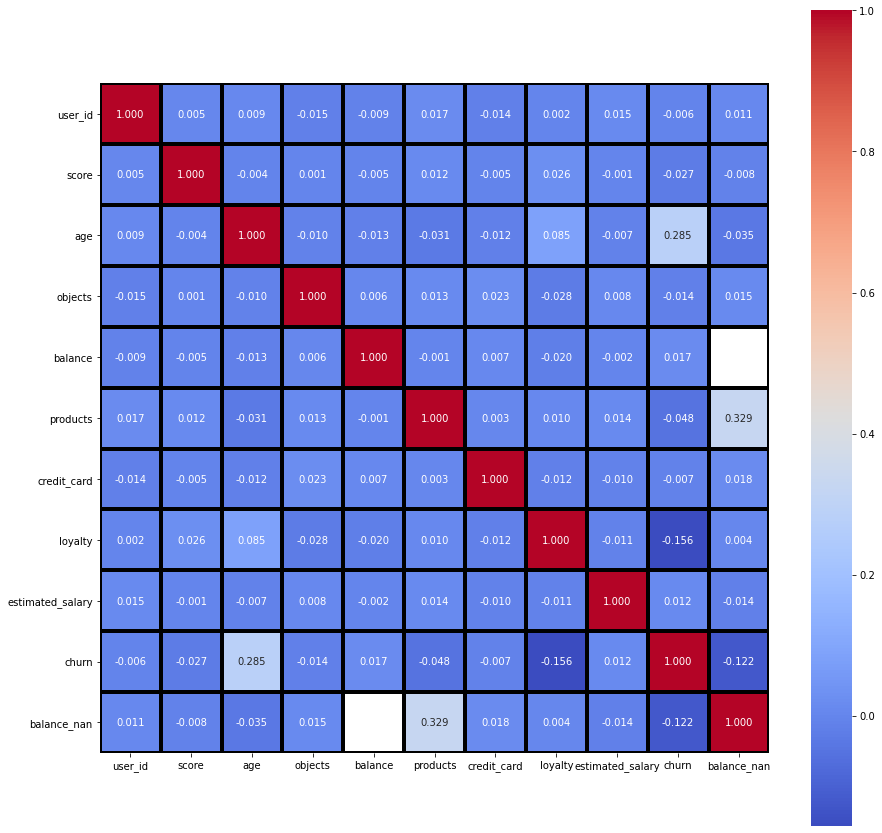

In [31]:
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt = '.3f', square=True, cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

Наблюдаем "условно" более высокую корреляцию между возрастом и показателем оттока. Также, есть взаимосвязь оттока с активностью. По показателям "связи" оттока с продуктовой линейкой, объектами и уровнем зарплата корреляция крайне слабая.

Тем не менее, есть предположение, что оттоку "подвержены" клиенты какой-то возрастной категории, плюс, обязательно стоит проверить зависимость количества ушедших по каждому из трех регионов, в которых есть отделения банка. Осуществим это на третьем шаге исследования.

Для дальнейших действий создадим новый датафрейм, в котором преобразуем категориальные переименные в количественные, чтобы иметь возможность проанализировать факт оттока по половому признаку или по городу

In [32]:
data_new = data.copy()
data_new = pd.get_dummies(data_new, columns=['gender','city'])
display(data_new.head())

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,balance_nan,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,15677338,619,42,2,NaN,1,1,1,101348.88,1,1,1,0,0,0,1
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,0,1,0
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,1,0,0,0,1
3,15744090,699,39,1,NaN,2,0,0,93826.63,0,1,1,0,0,0,1
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,0,1,0


In [33]:
cm_correct = data_new.corr()
cm_correct

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,balance_nan,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
user_id,1.000000,0.005308,0.009497,-0.014883,-0.008690,0.016972,-0.014025,0.001665,0.015271,-0.006248,0.010559,0.002641,-0.002641,-0.003097,0.007800,-0.004049
score,0.005308,1.000000,-0.003965,0.000842,-0.004744,0.012238,-0.005458,0.025651,-0.001384,-0.027094,-0.008380,0.002857,-0.002857,0.005538,0.004780,-0.008928
age,0.009497,-0.003965,1.000000,-0.009997,-0.012822,-0.030680,-0.011721,0.085472,-0.007201,0.285323,-0.034950,0.027544,-0.027544,0.046897,-0.001685,-0.039208
objects,-0.014883,0.000842,-0.009997,1.000000,0.005827,0.013444,0.022583,-0.028362,0.007784,-0.014001,0.015235,-0.014733,0.014733,-0.000567,0.003868,-0.002848
balance,-0.008690,-0.004744,-0.012822,0.005827,1.000000,-0.001027,0.006721,-0.020418,-0.001856,0.017208,NaN,-0.025742,0.025742,-0.002604,-0.000208,0.002759
products,0.016972,0.012238,-0.030680,0.013444,-0.001027,1.000000,0.003183,0.009612,0.014204,-0.047820,0.329294,0.021859,-0.021859,-0.010419,0.009039,0.001230
credit_card,-0.014025,-0.005458,-0.011721,0.022583,0.006721,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.018358,-0.005766,0.005766,0.010577,-0.013480,0.002467
loyalty,0.001665,0.025651,0.085472,-0.028362,-0.020418,0.009612,-0.011866,1.000000,-0.011421,-0.156128,0.004116,-0.022544,0.022544,-0.020486,0.016732,0.003317
estimated_salary,0.015271,-0.001384,-0.007201,0.007784,-0.001856,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.014486,0.008112,-0.008112,0.010297,-0.006482,-0.003332
churn,-0.006248,-0.027094,0.285323,-0.014001,0.017208,-0.047820,-0.007138,-0.156128,0.012097,1.000000,-0.122357,0.106512,-0.106512,0.173488,-0.052667,-0.104955


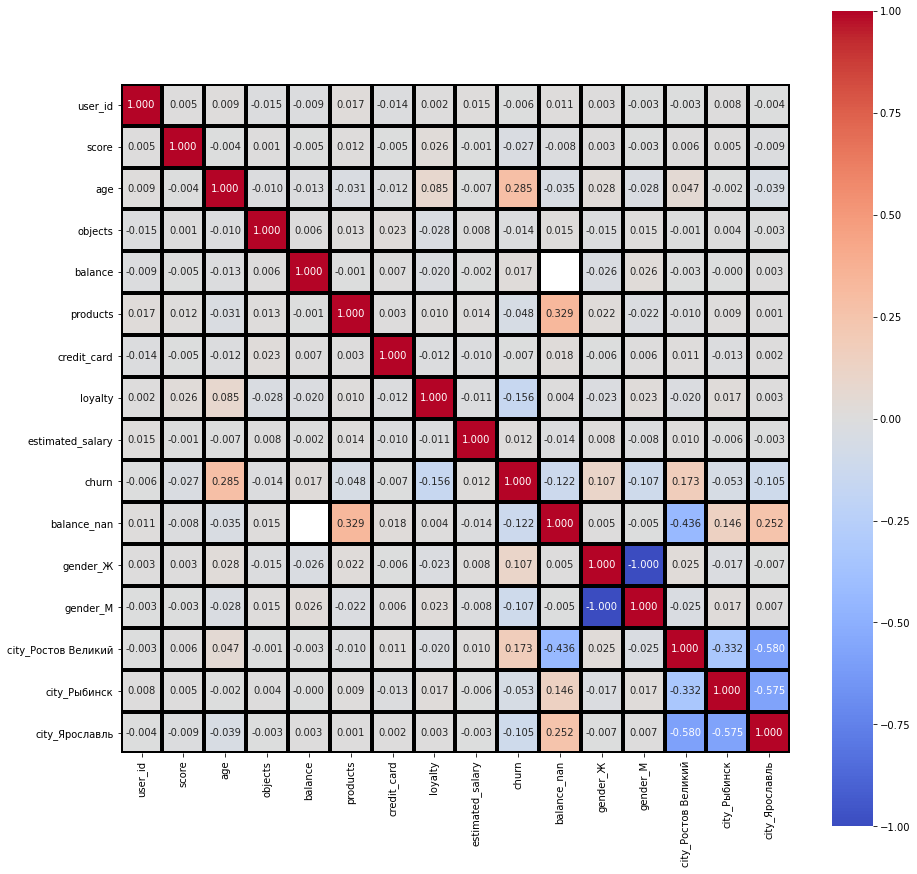

In [34]:
plt.figure(figsize=(15, 15))
sns.heatmap(cm_correct, annot=True, fmt = '.3f', square=True, cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

**Выводы:**
- Была осуществлена предобработка данных
- Составлен примерный портрет пользователя банка: 39 лет, на счету около 120000 рублей, заработная плата около 100000 рублей. Имеет 5 объектов в собственности и один продукт в банке
- Клиентов мужского пола в банке больше, чем женщин
- Выявлено предположение, что факт оттока связан с возрастом клиента, активностью, территориальным признаком и продуктами банка

# 3. Исследовательский анализ данных

## 3.1. Сравнение показателей/признаков действующих и ушедших клиентов

На прошлом шаге было установлено, что 7963 клиента являются действующими, в то время как 2037 покинули организацию и не являются клиентами. Или 80/20 в процентном соотношении.
Посмотрим на медианные значений по всем имеющимся данным в разрере фактора оттока, т.е. группировки по churn:

In [35]:
data_new.groupby('churn').agg('median').round(1)

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,balance_nan,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
churn,,,,,,,,,,,,,,,
0,15734279,653,36,5,119791.2,2,1,1,99645.0,0,0,1,0,0,1
1,15731699,646,45,5,119948.1,1,1,0,102460.8,0,1,0,0,0,0


Теперь "имеем право" составить "полноценный портрет" как действующего клиента, так и ушедшего:

**Действующий клиент:**
- Имеет рейтинг 653
- Возраст 36 лет
- 5 объектов в собственности
- Баланс около 120000
- 2 продукта в банке
- 1 кредитную карту
- Имеет активный статус
- Средний заработок чуть менее 100000 рублей

**Ушедший клиент:**
- Имеет рейтинг 646
- Возраст 45 лет
- 5 объектов в собственности
- Баланс около 120000
- 1 продукт в банке
- 1 кредитную карту
- Не имеет активного статуса
- Средней заработок около 102000 рублей

Также, сюда можно отнести косвенное заключение, что женщины более "подвержены" уходу, чем мужчины, а в Ярославле отток меньше, чем в двух других городах

## 3.2. Изучение распределения и зависимостей признаков

Посмотрим на распределение, характерное для количественных переменных:

In [36]:
current_clients = data.query('churn == 0')
departed_clients = data.query('churn == 1')

In [37]:
name_columns_1 = ['score', 'age', 'balance', 'estimated_salary']

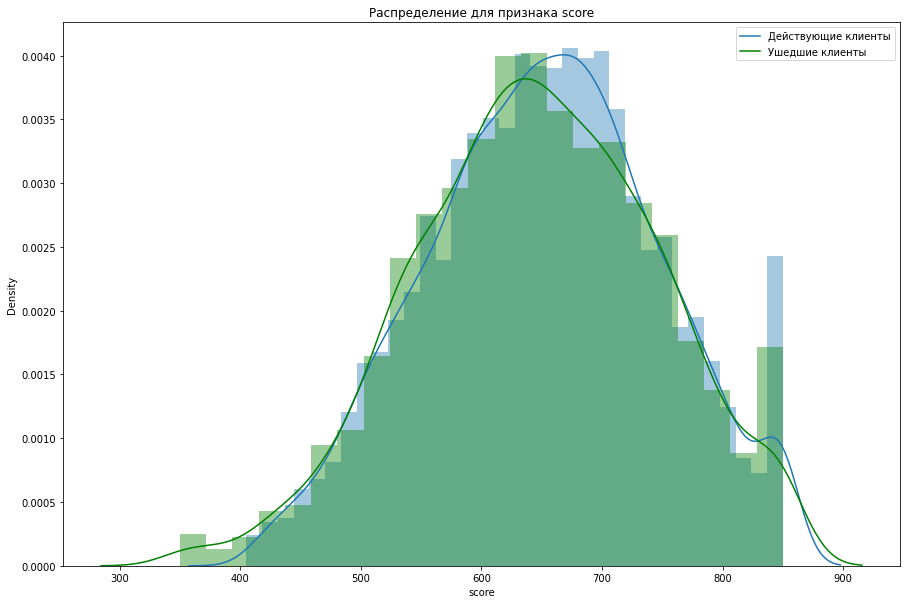

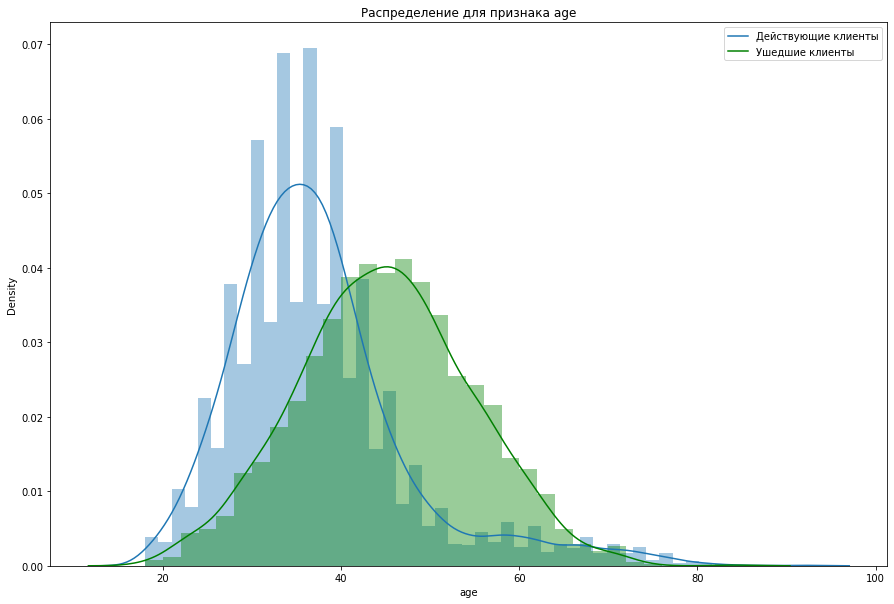

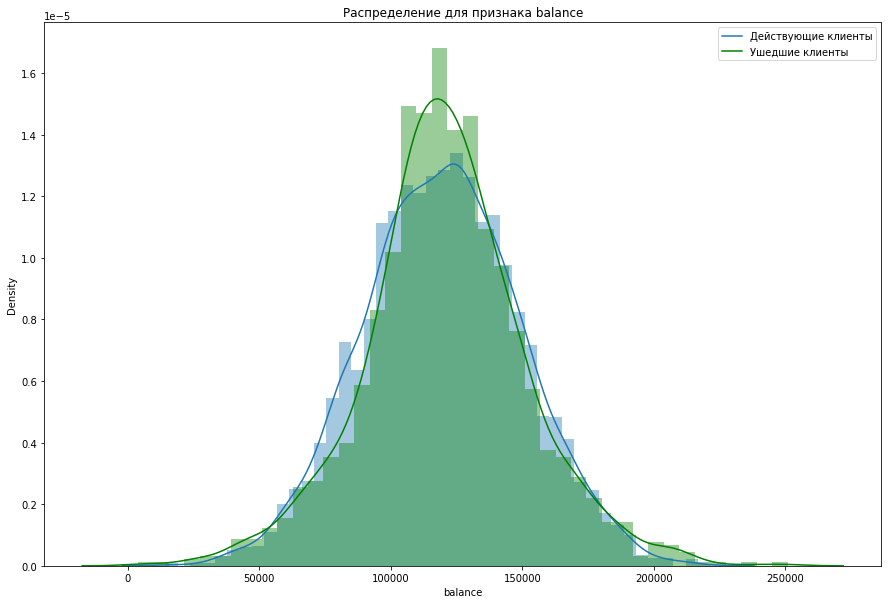

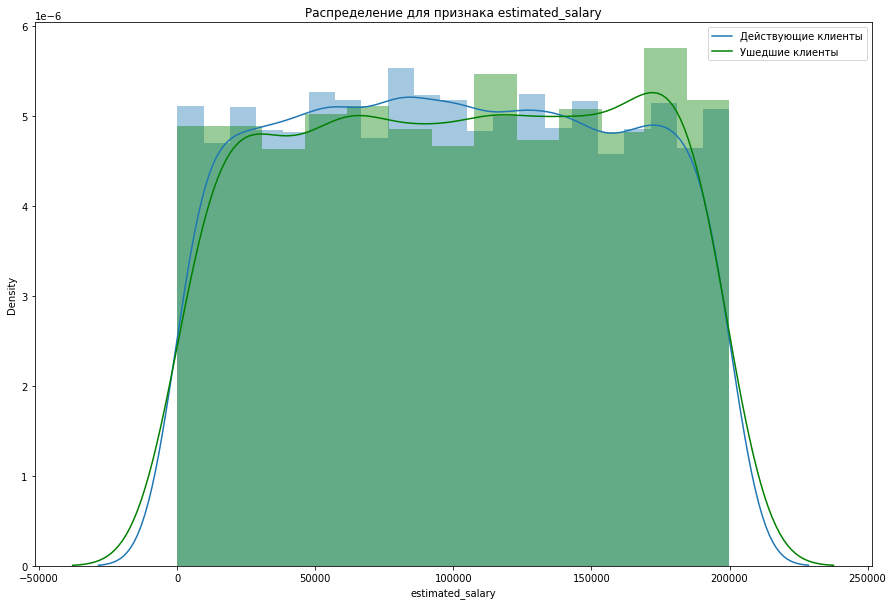

In [38]:
for col in name_columns_1:
    plt.figure(figsize=(15, 10))
    sns.distplot(current_clients[col])
    sns.distplot(departed_clients[col], color = 'g')
    plt.legend(labels = ('Действующие клиенты', 'Ушедшие клиенты'))
    plt.title('Распределение для признака ' + col)
    plt.show()

Распределения можно охарактеризовать, как близкие к нормальным. Распределение параметра зарплаты практически равномерно. В целом, графики подтверждают предположения и портрет клиента, сделанные ранее.

In [39]:
name_columns_2 = ['city', 'gender', 'credit_card', 'loyalty', 'objects', 'products']

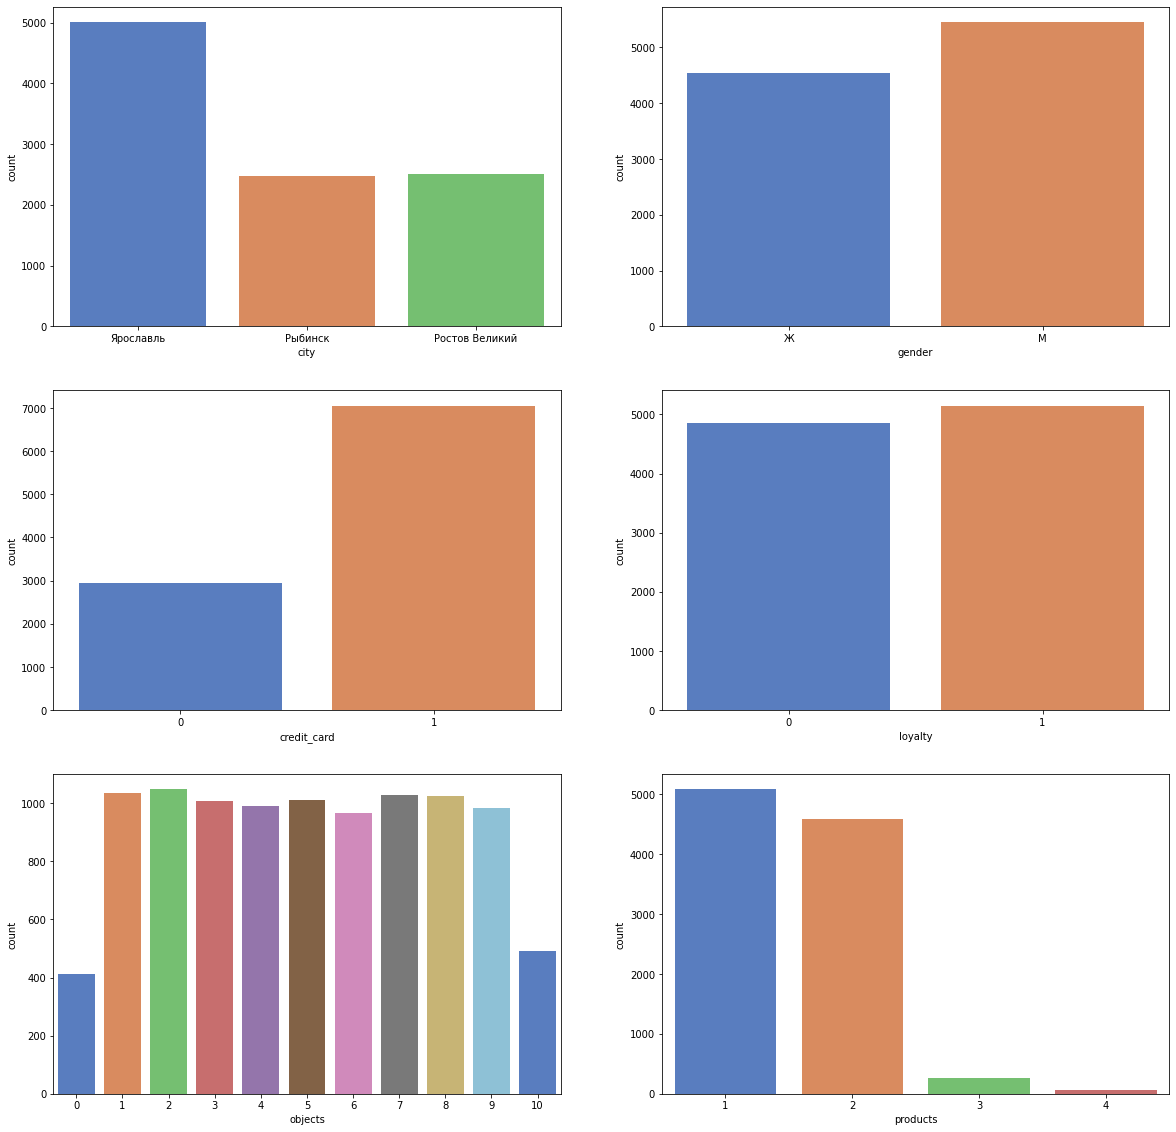

In [40]:
fig , ax = plt.subplots(3,2,figsize=(20,20))

for axis,column in zip(ax.flat, name_columns_2):
    sns.countplot(x=data[column], palette='muted', ax=axis)

- Больше всего клиентов в Ярославле, примерно столько же, как и в Рыбинске и Ростове Великом суммарно
- Клиентов мужского пола больше, чем женщин
- Количество клиентов с кредитной картой в 2 раза больше, чем тех, кто таким продуктом не пользуется
- Активных клиентов немного больше, чем неактивных, но в целом, значения близки к равным
- Количество объектов от одного до 9 примерно равно. Пожалуй, стоит признать, что среднее значение в 5 объектов (которое использовано при составлении портера пользователя) не совсем достоверно
- Чаще всего, клиенты имеют 1-2 продукта. Чтобы было 3-4 - крайне редкое явление

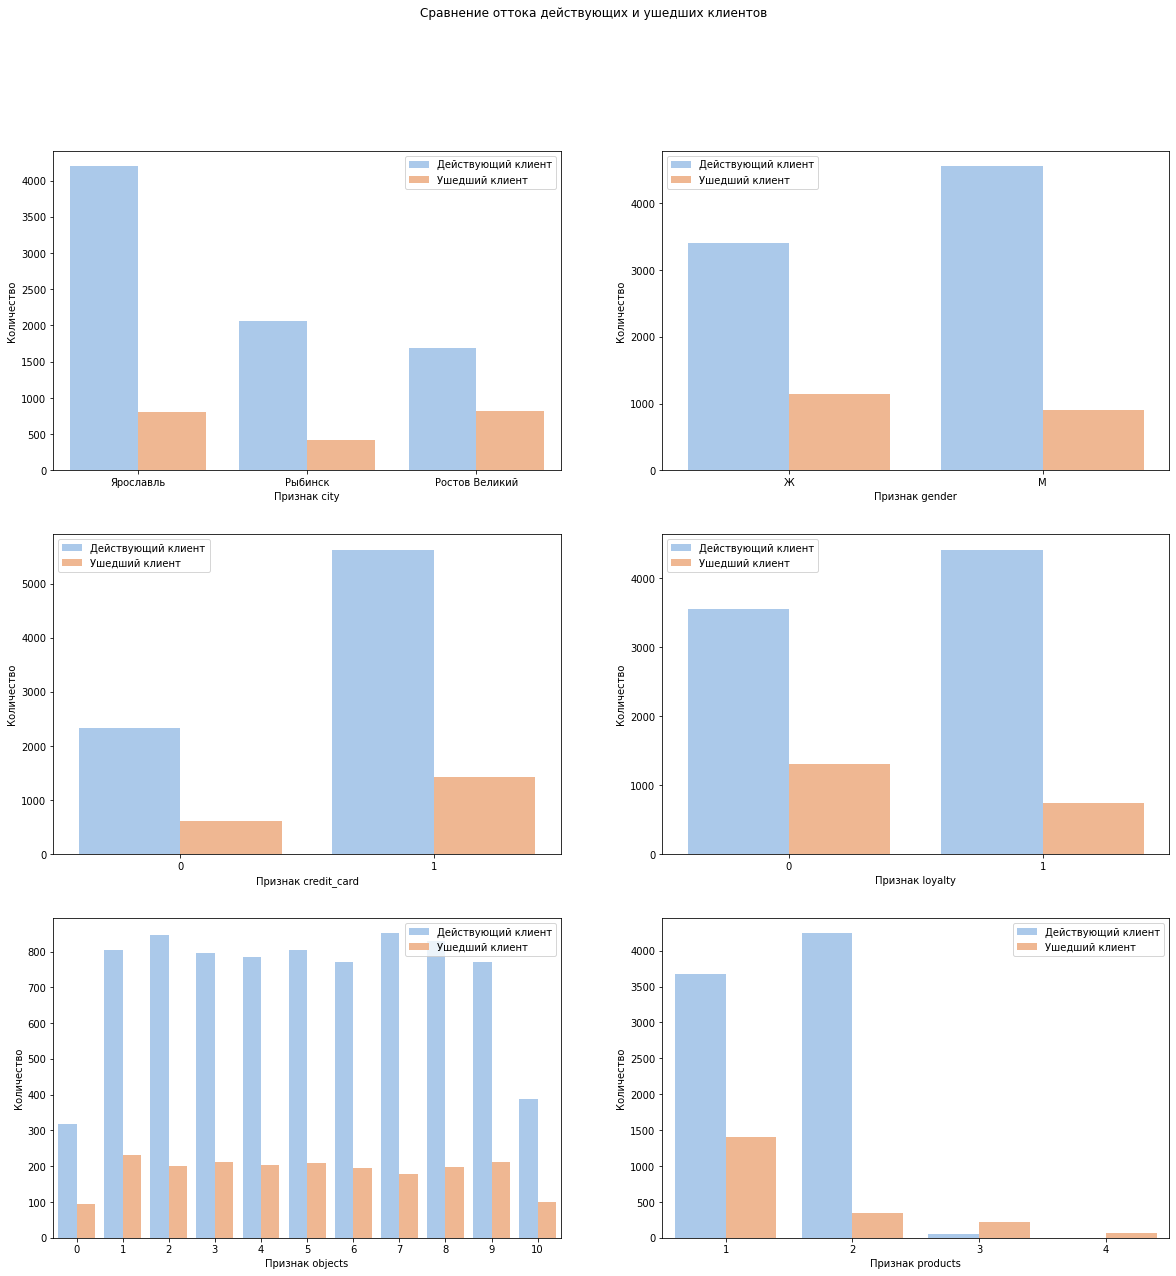

In [41]:
fig, ax = plt.subplots(3,2, figsize=(20, 20))
for variable, subplot in zip(name_columns_2, ax.flatten()):
    sns.countplot(data=data, x=variable, hue='churn', ax=subplot, palette="pastel")
    subplot.set_ylabel('Количество')
    subplot.set_xlabel('Признак {}'.format(variable))
    subplot.legend(labels=['Действующий клиент', 'Ушедший клиент'])
fig.suptitle("Сравнение оттока действующих и ушедших клиентов");

- В контексте соотношения действующий/ушедший клиент лучше всего обстоят дела в Ярославле, в Ростове Великом же отток близок к половине количества оставшихся клиентов
- Клиенты мужского пола менее подвержены оттоку, по сравнению с женщинами
- Соотношение по количеству ушедших между тему у кого есть кредитная карта и теми, у кого ее нет примерно равное
- Среди неактивных клиентов уходит меньшее количество, чем среди тех, кто имеет активный статус
- Показатели оттока в зависимости от количества объектов в собственности примерно равны
- Наиболее часто уходят клиенты с одним продуктом, а вот среди клиентов с двумя продуктами показатель значительно лучше

## 3.2. Сравнение показателей/признаков действующих и ушедших клиентов в зависимости от количества банковских продуктов

In [42]:
data_new.groupby('churn')['products'].mean()

churn
0    1.544267
1    1.475209
Name: products, dtype: float64

Видим в среднем 1,5 продукта, конечно, такого не бывает. Склоняюсь описать это так: имеют не менее одного продукта банка

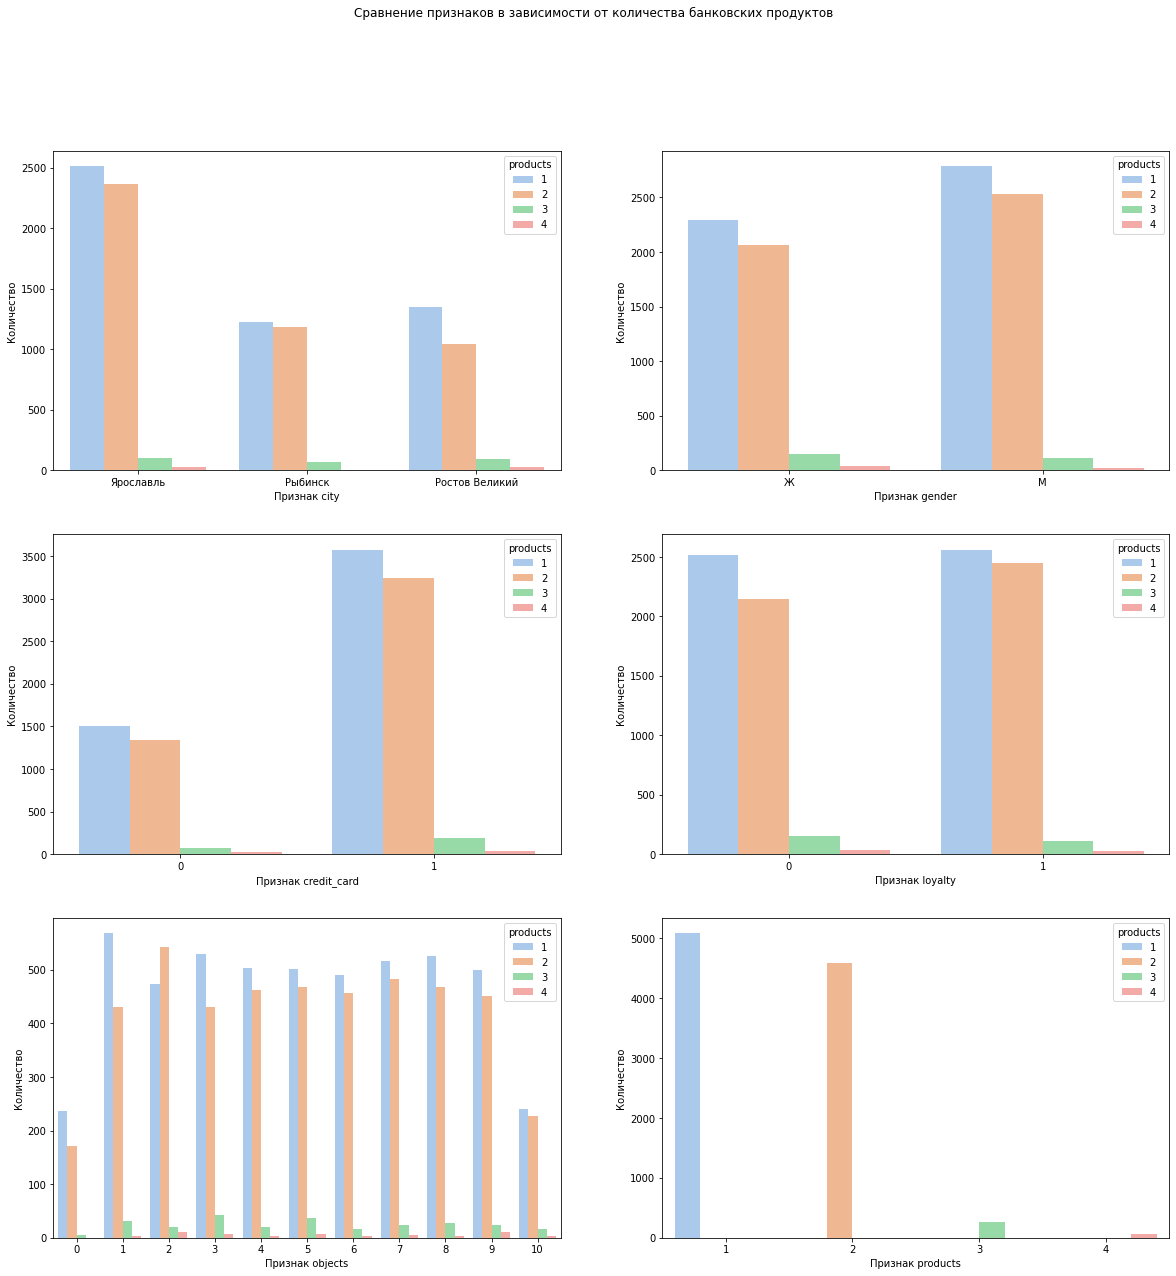

In [43]:
fig, ax = plt.subplots(3,2, figsize=(20, 20))
for variable, subplot in zip(name_columns_2, ax.flatten()):
    sns.countplot(data=data, x=variable, hue='products', ax=subplot, palette="pastel")
    subplot.set_ylabel('Количество')
    subplot.set_xlabel('Признак {}'.format(variable))

fig.suptitle("Сравнение признаков в зависимости от количества банковских продуктов");

Данная иллюстрация не дает оснований опровергнуть или дополнить ранее изложенные доводы: по всем признакам 3-4 продукта имеют крайне мало клиентов, вне зависимости от прочих факторов

## 3.3. Сравнение показателей/признаков действующих и ушедших клиентов в зависимости от местоположения банка (территориального признака)

In [44]:
rostov_churn = data_new.groupby('churn')['city_Ростов Великий'].mean()
rostov_churn = rostov_churn * 100
rostov_churn = rostov_churn.map('{0:.2f}%'.format)
display(rostov_churn)

churn
0    21.29%
1    39.96%
Name: city_Ростов Великий, dtype: object

In [45]:
rybinsk_churn = data_new.groupby('churn')['city_Рыбинск'].mean()
rybinsk_churn = rybinsk_churn * 100
rybinsk_churn = rybinsk_churn.map('{0:.2f}%'.format)
display(rybinsk_churn)

churn
0    25.92%
1    20.27%
Name: city_Рыбинск, dtype: object

In [46]:
yaroslavl_churn = data_new.groupby('churn')['city_Ярославль'].mean()
yaroslavl_churn = yaroslavl_churn * 100
yaroslavl_churn = yaroslavl_churn.map('{0:.2f}%'.format)
display(yaroslavl_churn)

churn
0    52.79%
1    39.76%
Name: city_Ярославль, dtype: object

Видим, что в Ростове Великом и Ярославле примерно равные проценты оттока, почти 40%. Цифра весьма неприятная. В Рыбинске ситуация несколько лучше - отток составляет 25%

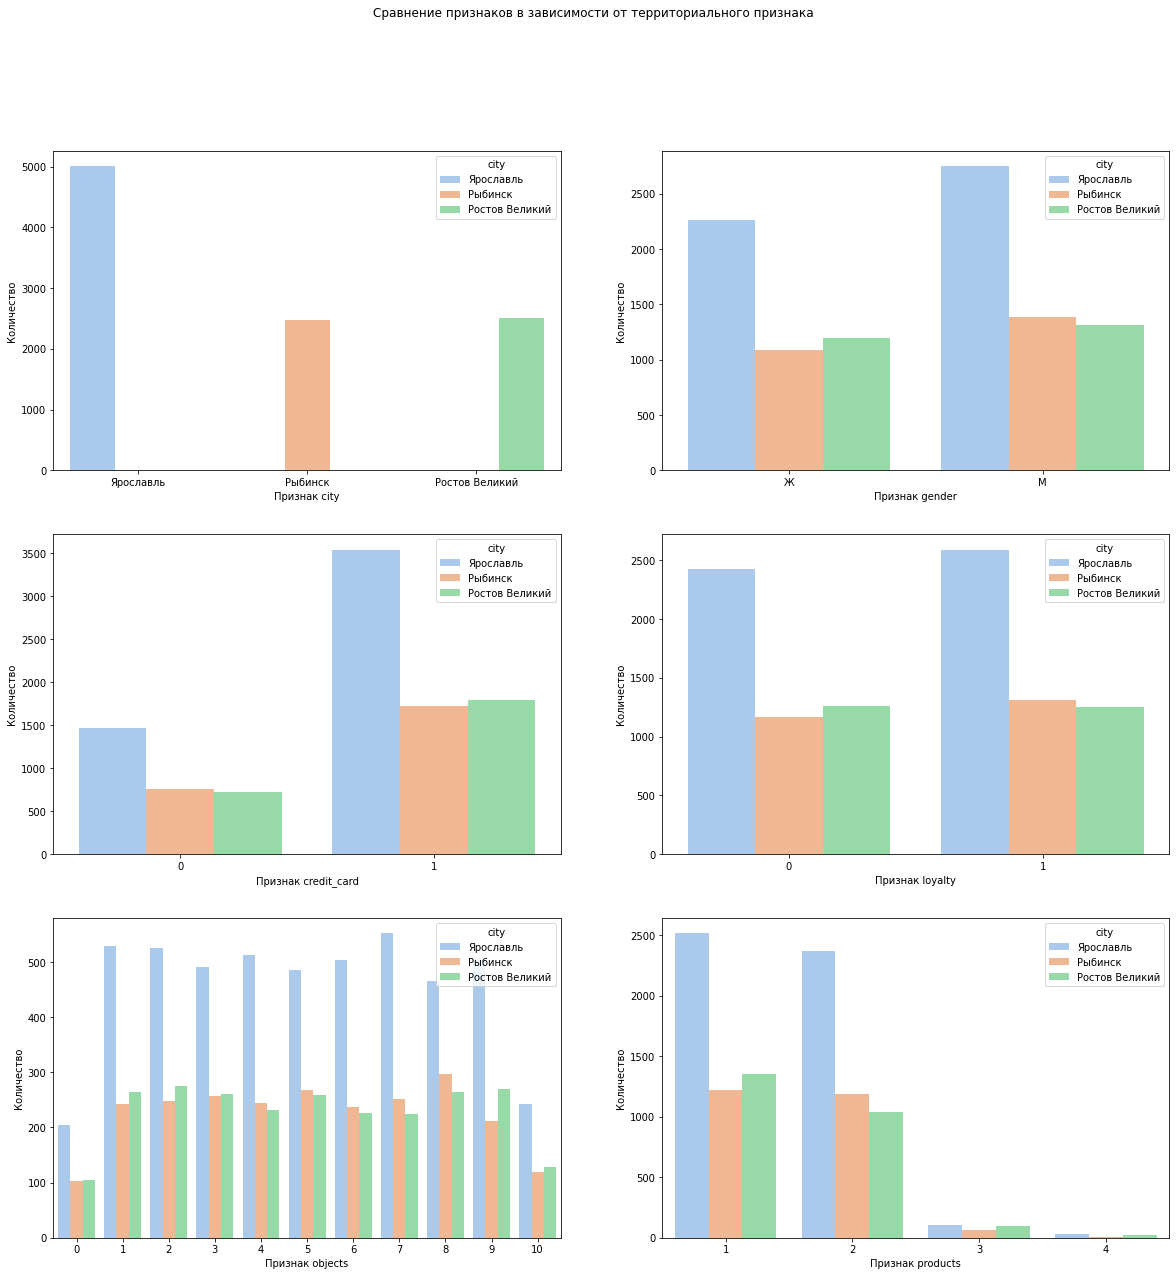

In [47]:
fig, ax = plt.subplots(3,2, figsize=(20, 20))
for variable, subplot in zip(name_columns_2, ax.flatten()):
    sns.countplot(data=data, x=variable, hue='city', ax=subplot, palette="pastel")
    subplot.set_ylabel('Количество')
    subplot.set_xlabel('Признак {}'.format(variable))
    
fig.suptitle("Сравнение признаков в зависимости от территориального признака");

С учетом ранее описанного наблюдения, что наиболее "востребованным" из трех филиалов является Ярославль, логично, что по многим критериям он будет "впереди". Можно отметить, что во всех городах больше клиентов имеют кредитки, по сравнению с теми, у кого их нет

## 3.4. Сравнение показателей/признаков действующих и ушедших клиентов в зависимости от пола клиента

In [48]:
woman_churn = data_new.groupby('churn')['gender_Ж'].mean()
woman_churn = woman_churn * 100
woman_churn = woman_churn.map('{0:.2f}%'.format)
display(woman_churn)

churn
0    42.75%
1    55.92%
Name: gender_Ж, dtype: object

In [49]:
men_churn = data_new.groupby('churn')['gender_М'].mean()
men_churn = men_churn * 100
men_churn = men_churn.map('{0:.2f}%'.format)
display(men_churn)

churn
0    57.25%
1    44.08%
Name: gender_М, dtype: object

Среди клиентов банка женщины уходят чаще мужчин: 55% против 44%

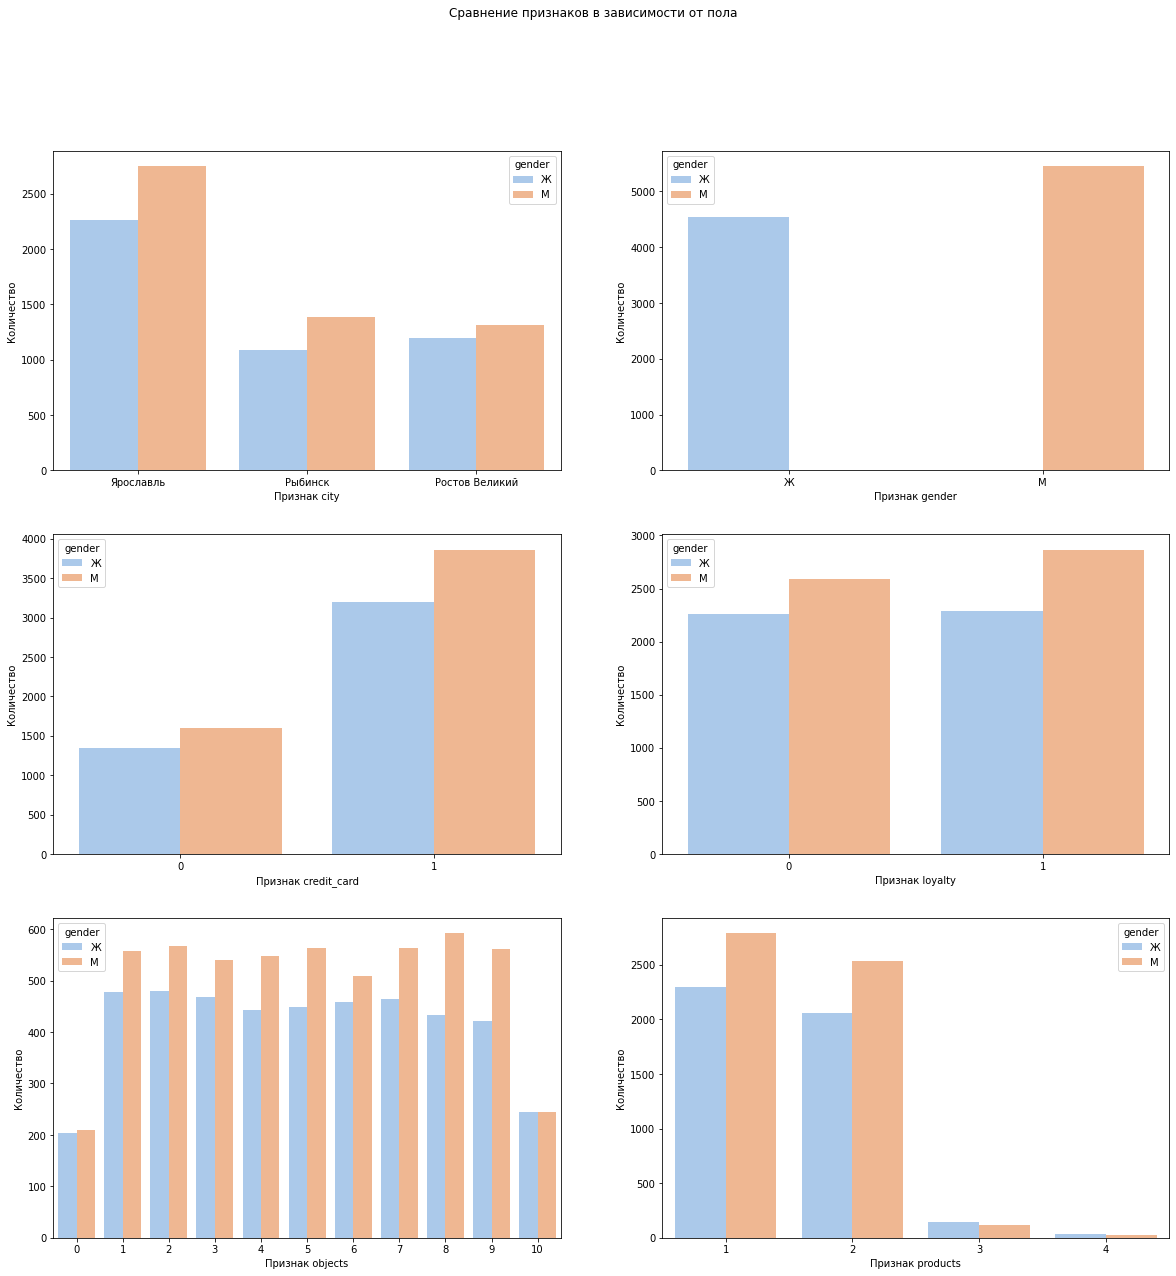

In [50]:
fig, ax = plt.subplots(3,2, figsize=(20, 20))
for variable, subplot in zip(name_columns_2, ax.flatten()):
    sns.countplot(data=data, x=variable, hue='gender', ax=subplot, palette="pastel")
    subplot.set_ylabel('Количество')
    subplot.set_xlabel('Признак {}'.format(variable))
    
fig.suptitle("Сравнение признаков в зависимости от пола");

Этот график также логичен, с учетом того, что мужчин среди клиентов банка изначально больше. Но, есть интересное наблюдение: 3-4 продукта чаще встречается у женщин, чем у мужчин

## 3.5. Сравнение показателей/признаков действующих и ушедших клиентов в зависимости от возраста клиента

In [51]:
data_new.groupby('churn')['age'].mean()

churn
0    37.408389
1    44.837997
Name: age, dtype: float64

Клиенты, условно относящиеся к категории "40+" более часто покидают банк

## 3.6. Кластеризация методами машинного обучения

In [52]:
data_cluster = data.drop(columns=['city', 'gender'])
data_cluster = data_cluster.fillna(0)

In [53]:
scaler = StandardScaler()
X_st = scaler.fit_transform(data_cluster)
linked = linkage(X_st, method = 'ward')

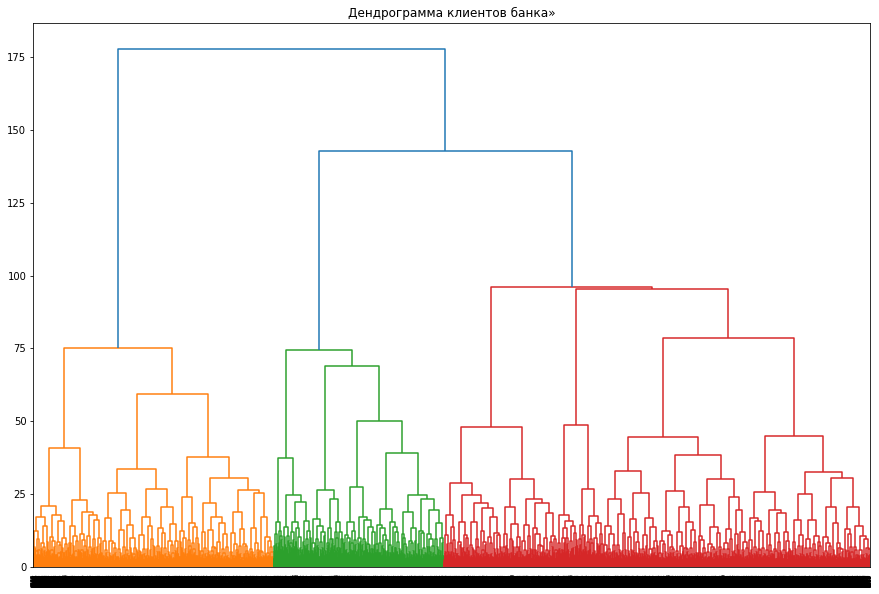

In [54]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма клиентов банка»')
plt.show()

In [55]:
k_means = KMeans(n_clusters = 3, random_state=0)

# прогнозируем кластеров для наблюдений
labels = k_means.fit_predict(X_st)

#устанавливаем соответствие между каждым наблюдением и значением кластера 
data['cluster_kmeans'] = labels

In [56]:
cluster_mean = data.groupby(['cluster_kmeans']).mean()
cluster_mean

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,balance_nan
cluster_kmeans,,,,,,,,,,,
0,1.573469e+07,650.507394,37.524646,5.102280,49508.790000,1.861984,0.718731,0.540974,98498.444982,0.039433,0.999692
1,1.573338e+07,652.816718,37.417750,4.981631,119550.317742,1.360372,0.699690,0.561816,100512.693375,0.000000,0.000000
2,1.573270e+07,644.758512,45.114720,4.939759,120746.971132,1.397067,0.697748,0.352541,101724.697224,1.000000,0.194866


Итак, алгоритмы машинного обучения разделили имеющиеся данные на 3 кластера. Опишем наиболее интересующие моменты:

**Кластер 1:**
- рейтинг 650 баллов
- возраст 37 лет
- 5 объектов в собственности
- 70000 на балансе
- 2 продукта
- 71% имеют кредитную карту
- 54% активны
- средняя зарплата 97000

**Кластер 2:**
- рейтинг 653 балла
- возраст 38 лет
- 5 объектов в собственности
- 122000 на балансе
- 1 продукт
- 70% имеют кредитную карту
- 56% активны
- средняя зарплата 100000

**Это наименее склонный к оттоку кластер**

**Кластер 3:**
- рейтинг 645 баллов
- возраст 45 лет
- 5 объектов в собственности
- 121000 на балансе
- 1 продукт
- 70% имеют кредитную карту
- 35% активны
- средняя зарплата 101000

**Это наиболее склонный к оттоку кластер**

## 3.7. Выводы

Резюмируя: портрет ушедшего клиента, найденный "вручную" во многом идентичен с результатами кластеризации методами машинного обучения. Можно считать, что портрет условно "достоверным" и передать бизнесу эти наблюдения для принятия мер по удержанию клиента

**Закономерности, выявленные на стадии исследовательского анализа данных:**
- Больше всего клиентов в Ярославле, примерно столько же, как в Рыбинске и Ростове Великом суммарно
- Клиентов мужского пола больше, чем женщин
- Количество клиентов с кредитной картой в 2 раза больше, чем тех, кто таким продуктом не пользуется
- Активных клиентов немного больше, чем неактивных, но в целом, значения близки к равным
- Количество объектов от одного до 9 примерно равно. Среднее значение – 5
- Чаще всего, клиенты имеют 1-2 продукта
- В контексте соотношения действующий/ушедший клиент лучше всего обстоят дела в Ярославле, в Ростове Великом же отток близок к половине количества клиентов
- Наиболее часто уходят клиенты с одним продуктом, а вот среди клиентов с двумя продуктами показатель значительно лучше
-3-4 продукта чаще встречается у женщин, чем у мужчин

**Портрет потребителя наименее склонного к оттоку:**
- рейтинг 653 балла
- возраст 38 лет
- 5 объектов в собственности
- 122000 на балансе
- 1 продукт
- 70% имеют кредитную карту
- 56% активны
- средняя зарплата 100000

**Портрет потребителя наиболее склонного к оттоку:**
- рейтинг 645 баллов
- возраст 45 лет
- 5 объектов в собственности
- 121000 на балансе
- 1 продукт
- 70% имеют кредитную карту
- 35% активны
- средняя зарплата 101000

# 4. Проверка гипотез

## 4.1. Формирование гипотез

**Гипотеза №1:**
Имеются различия уровня дохода между теми клиентами, которые ушли и теми, которые остались.
- Нулевая гипотеза: уровень дохода равен
- Альтернативная гипотеза: уровень дохода различен

**Гипотеза №2:**
Имеются различия в контексте среднего возраста действующего и ушедшего клиента банка
- Нулевая гипотеза: возраст равен
- Альтернативная гипотеза: возраст имеет различия

**Гипотеза №3:**
Имеются различия в количестве продуктов, между ушедшими клиентами и теми, кто остались
- Нулевая гипотеза: количество продуктов равно
- Альтернативная гипотеза: количество продуктов различно

## 4.2. Формирование гипотез

**Проверка гипотезы №1**

In [57]:
alpha = 0.05 

results = st.ttest_ind(
    current_clients['estimated_salary'], 
    departed_clients['estimated_salary'], equal_var = False)

print('p-значение: ', results.pvalue)  

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print()
print('Средний доход действующих клиентов банка', current_clients['estimated_salary'].mean().round(2))
print('Средний доход ушедших клиентов банка', departed_clients['estimated_salary'].mean().round(2))

p-значение:  0.228924613051458
Не получилось отвергнуть нулевую гипотезу

Средний доход действующих клиентов банка 99738.39
Средний доход ушедших клиентов банка 101465.68


Верна нулевая гипотеза, следовательно, в рамках статистического теста наблюдаем равенство показателей. Уровень зарплаты клиента не является очевидной причиной оттока

**Проверка гипотезы №2**

In [58]:
alpha = 0.05 

results = st.ttest_ind(
    current_clients['age'], 
    departed_clients['age'], equal_var = False)

print('p-значение: ', results.pvalue)  

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print()
print('Средний возраст действующего клиента банка', current_clients['age'].mean().round(1))
print('Средний возраст ушедшего клиента банка', departed_clients['age'].mean().round(1))

p-значение:  4.7127272656641046e-179
Отвергаем нулевую гипотезу

Средний возраст действующего клиента банка 37.4
Средний возраст ушедшего клиента банка 44.8


Верна альтернативная гипотеза: средний возраст склонного к оттоку клиента выше, чем действующего клиента

**Проверка гипотезы №3**

In [59]:
alpha = 0.05 

results = st.ttest_ind(
    current_clients['products'], 
    departed_clients['products'], equal_var = False)

print('p-значение: ', results.pvalue)  

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print()
print('Среднее количество продуктов среди действующих клиентов банка', current_clients['products'].mean().round(2))
print('Среднее количество продуктов среди ушедших клиентов банка', departed_clients['products'].mean().round(2))

p-значение:  0.00021858494460549394
Отвергаем нулевую гипотезу

Среднее количество продуктов среди действующих клиентов банка 1.54
Среднее количество продуктов среди ушедших клиентов банка 1.48


По этой гипотезе верна альтернативная версия. Видим, что среднее количество продуктов у действующих клиентов банка, среди покинувших показатель меньше, пусть и не многократно. Возможно, имеется некая причина, почему клиенту неинтересно/невыгодно приобретать другие продукты, не исключено, что где-то ему предлагают лучшие условия и, постепенно, клиент перейдет в статус "ушедшего"

# 5. Выводы по итогам исследования

В ходе исследования были сделаны следующие выводы:
- Больше всего клиентов в Ярославле, примерно столько же, как и в Рыбинске и Ростове Великом суммарно
- Количество клиентов с кредитной картой в 2 раза больше, чем тех, кто таким продуктом не пользуется
- Чаще всего, клиенты имеют 1-2 продукта. Чтобы было 3-4 - крайне редкое явление. Тем не менее, большое количество продуктов встречается чаще у женщин, чем у мужчин
- В контексте соотношения действующий/ушедший клиент лучше всего обстоят дела в Ярославле, в Ростове Великом же отток близок к половине количества оставшихся клиентов
- Соотношение по количеству ушедших между тему у кого есть кредитная карта и теми, у кого ее нет примерно равное
- Наиболее часто уходят клиенты с одним продуктом, а вот среди клиентов с двумя продуктами показатель значительно лучше

Также, менеджеру продукта рекомендуется ознакомиться с портретами действующих и ушедших клиентов: возможно, какие-то признаки будут "коррелировать" с уже подмеченными "болевыми точками", другими исследованиями и прочим.

**Портрет клиента, не склонного к оттоку:**
- рейтинг 653 балла
- возраст 38 лет
- 5 объектов в собственности
- 122000 на балансе
- 1 продукт
- 70% имеют кредитную карту
- 56% активны
- средняя зарплата 100000

**Портрет клиента, склонного к оттоку:**
- рейтинг 645 баллов
- возраст 45 лет
- 5 объектов в собственности
- 121000 на балансе
- 1 продукт
- 70% имеют кредитную карту
- 35% активны
- средняя зарплата 101000

**Резюмируя:**
- в связи с тем, что в Ростове Великом и Ярославле наблюдается отток примерно в 40%, тогда как в Рыбинске этот показатель меньше в два раза, стоит обратить внимание на доступность отделений банка и качество сервисов. Как пример: недостаточно развита сеть банкоматов, клиенту легче уйти в другой банк, чем продумывать логистику, и.т.п.
- поскольку, к оттоку более склонны клиенты возраста 40+ следует обратить внимание на градацию сервисов в зависимости от возрастной категории. Наверняка, существуют какие-то аналоги молодежной и пенсионных карт. Также, если клиента возраста 20+ можно "заманить", например, индивидуальным дизайном карты, то другим возрастным сегментам это может быть неинтересно. Видится разработка внедрения кэшбека на отдельные категории товаров, выход на зарплатные проекты, и.т.п.
- клиенты, которые склонны покинуть банк в 20% случаев менее "активны". Вероятно, возникают некие препятствия дальнейшему сотрудничеству с банком, начиная от различных технических неполадок и заканчивая проигранной конкуренцией. Рекомендуется проанализировать всю имеющуюся обратную связь и принять конструктивные меры
- наблюдаем, что 3-4 продукт в банке крайне редко встречается у клиентов. Разумеется, взять какой-то банковский продукт - это не приобрести дополнительное занятие в условном фитнес-центре, однако, нельзя исключать, что отсутствует программа лояльности, возможность реструктуризации, и.т.п. Эта же мысль связана с оттоком по вероятной причине проигранной конкуренции, может быть, где-то предлагают лучшие условия и возможность иметь, условно, 10 продуктов без рисков для клиента
- поскольку у нас есть неактивные клиенты, которые еще не ушли - следует наладить систему информирования (ненавязчивую!), например, обзвон или приглашение в отделение банка (смотря какой "статус" клиента), в ходе которого уточнять причины потенциального ухода из банка и предлагать эквивалентные способы решения проблемы
- стоит в целом провести аудит качества предлагаемых услуг и их доступности
- необходимо проверить соответствие предлагаемых продуктов целевой аудитории. Например, нет смысла пенсионеру предлагать кредит на учебу в ВУЗе, и.т.п.